In [1]:
import os
import io
import sys
import json
import boto3 
import pymongo 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image
from urllib import request


In [12]:
DOWNLOAD_RESULTS = False

In [13]:
if os.path.exists("../experiments/auth.json"):
    auth = json.load(open("../experiments/auth.json", "rb"))
    MONGO_USER = auth["mongo_user"]
    MONGO_PW = auth["mongo_pw"]

EXPERIMENT_NAME = "static_detection_pilot_v1"
S3_BUCKET_NAME = "gestalt-scenes"

In [14]:
def open_connection(db="psychophys"):
    client = pymongo.MongoClient(
        f"mongodb+srv://{MONGO_USER}:{MONGO_PW}@"
        + f"psychophys.js4h5.mongodb.net/{db}"
        + "?retryWrites=true&w=majority"
    )
    return client


In [15]:
def download_results(db="psychophys"):
    client = open_connection()
    db = client[db]
    col = db[EXPERIMENT_NAME]
    cursor = col.find({})
    results = []
    for document in cursor:
        trial_data = document["trial_data"]
        trial_data["user_id"] = document["user_id"]
        results.append(trial_data)
    
    df = pd.DataFrame(results)
    return df

In [16]:
def download_from_s3(url, resource_type="image"):
    s3 = boto3.resource('s3', region_name="us-east-2")
    bucket = s3.Bucket(S3_BUCKET_NAME)
    item = bucket.Object(url)
    if resource_type == "image":
        file_stream = io.BytesIO()
        item.download_fileobj(file_stream)
        img = Image.open(file_stream)
        return img
    
    else:
        return item

In [17]:
def download_from_url(url):
    obj = request.urlretrieve(url)
    image = Image.open(obj[0])
    return image

In [18]:
def process_box(box):
    """
    Expects box as a tuple, of start stop points. Returns it as: [minX, minY, maxX, maxY]
    """
    minX = min(box[0][0], box[1][0])
    maxX = max(box[0][0], box[1][0])
    
    minY = min(box[0][1], box[1][1])
    maxY = max(box[0][1], box[1][1])
    
    return [int(minX), int(minY), int(maxX), int(maxY)]

def calc_mIOU(box_a, box_b, epsilon=1e-8):
        
    if len(box_a) < 4:
        a = process_box(box_a)
    else:
        a = box_a
    
    if len(box_b) < 4:
        b = process_box(box_b)
    else:
        b = box_b
        
    # return np.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)

    # COORDINATES OF THE INTERSECTION BOX
    
    xA = max(a[0], b[0])
    yA = max(a[1], b[1])
    xB = min(a[2], b[2])
    yB = min(a[3], b[3])
    
    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # compute the area of both AABBs
    bb1_area = (a[2] - a[0] + 1) * (a[3] - a[1] + 1)
    bb2_area = (b[2] - b[0] + 1) * (b[3] - b[1] + 1)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou


In [19]:
if DOWNLOAD_RESULTS:
    df = download_results()
else:
    df = pd.read_csv(f"{EXPERIMENT_NAME}-results.csv")

In [20]:
df.to_csv(EXPERIMENT_NAME + "-results.csv")

# Generate cleaned version

In [10]:
df.head()

,rt,stimulus,response,correct,probe_location,probe_touching,subject_bounding_box,trial_type,trial_index,time_elapsed,...,n_objs,obj_location_data,obj_rotation_data,obj_scaling_data,obj_shape_data,obj_shape_type,obj_texture_data,scene,texture,user_id
0,8613,https://gestalt-scenes.s3.us-east-2.amazonaws....,1,False,"[433, 433]",True,[],probe-detection-task,5,107555,...,2,"[12.70596044597132, -2.984492865811304, -4.979...","[-0.270840468143005, 0.8424603500755907, 0.352...","[3.5, 3.5, 3.5, 7]","[1.4454060325122622, 0.7242645841772491, 2.619...",superellipsoid,"{'params': {'Detail': 0.43260807997835227, 'De...",scene_008,test_wave,60cb62a4e099dcbffe591021
1,9112,https://gestalt-scenes.s3.us-east-2.amazonaws....,0,False,"[461, 52]",False,"[[471, 58.59375], [435, 26.59375]]",probe-detection-task,6,116672,...,1,"[-2.7804630343021484, -7.759888384293469, 6.77...","[0.6616858375968595, -0.06503758779568934, -0....","[4, 4, 4, 8]","[2.924762916184597, 3.330682762717349, 2.01459...",superellipsoid,"{'params': {'Randomness': 0.9899038756116822, ...",scene_002,test_voronoi,60cb62a4e099dcbffe591021
2,4628,https://gestalt-scenes.s3.us-east-2.amazonaws....,1,False,"[287, 44]",True,[],probe-detection-task,7,121306,...,4,"[7.5065736075335385, -4.015920287979006, 10.84...","[-0.9801724878485439, 0.10134506457258154, -0....","[2, 2, 2, 4]","[1.1971993981114757, 1.8404215375903812, 2.015...",superellipsoid,"{'params': {'Detail': 0.21333254317200923, 'De...",scene_006,test_wave,60cb62a4e099dcbffe591021
3,11446,https://gestalt-scenes.s3.us-east-2.amazonaws....,0,True,"[271, 338]",True,"[[280, 348.59375], [247, 317.59375]]",probe-detection-task,8,132756,...,4,"[-0.24318274382809993, 1.483900827074323, -8.1...","[0.9888308262251285, 0.02182296494045618, -0.1...","[2.5, 2.5, 2.5, 5]","[0.4362559320433207, 3.0417987589463014, 0.506...",superellipsoid,"{'params': {'Randomness': 0.9250909000738976, ...",scene_006,test_voronoi,60cb62a4e099dcbffe591021
4,5762,https://gestalt-scenes.s3.us-east-2.amazonaws....,0,False,"[345, 305]",False,"[[353, 314.59375], [329, 293.59375]]",probe-detection-task,9,138524,...,2,"[1.3635001946241534, 2.140044264276118, 5.0772...","[0.766044443118978, -0.5021146691943527, -0.39...","[3.5, 3.5, 3.5, 7]","[1.7229271155218084, 3.5552774146477284, 2.580...",superellipsoid,"{'params': {'Randomness': 0.950623340143609, '...",scene_003,test_voronoi,60cb62a4e099dcbffe591021


In [34]:
participants = df.groupby("user_id")
participants_failed = []
i = 0 
for index, user_results in participants:
    i += 1


    if len(user_results) < 125:
        participants_failed.append(user_results["user_id"].iloc[0])
        continue
    
#     if user_results["correct"].mean() < 0.3:
#         participants_failed.append(user_results["user_id"].iloc[0])
#         continue
        
    attention_checks = user_results[user_results["stimulus"].str.contains("ground_truth")]
    if attention_checks["correct"].sum() < 5:
        participants_failed.append(user_results["user_id"].iloc[0])

participants_failed.append("60cb62a4e099dcbffe591021")
participants_failed.append("5ec3d06016290204b072564d")
print(participants_failed)

failed_participants = df["user_id"].apply(lambda x: x in participants_failed)
attention_filtered = df[~failed_participants]
attention_checks = attention_filtered["stimulus"].apply(lambda x: "ground_truth" in x)
attention_filtered = attention_filtered[~attention_checks]

['5e121bea1d460787c3d55e1f', '610504b105593e06be79291f', '60cb62a4e099dcbffe591021', '5ec3d06016290204b072564d']


In [35]:
attention_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4320 entries, 8 to 4910
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   rt                    4320 non-null   int64 
 1   stimulus              4320 non-null   object
 2   response              4320 non-null   int64 
 3   correct               4320 non-null   bool  
 4   probe_location        4320 non-null   object
 5   probe_touching        4320 non-null   bool  
 6   subject_bounding_box  4320 non-null   object
 7   trial_type            4320 non-null   object
 8   trial_index           4320 non-null   int64 
 9   time_elapsed          4320 non-null   int64 
 10  internal_node_id      4320 non-null   object
 11  background_texture    4320 non-null   object
 12  frame_idx             4320 non-null   int64 
 13  gt_bounding_box       4320 non-null   object
 14  image_url             4320 non-null   object
 15  mask_idx              4320 non-null   

# Create directory for figures

In [36]:
if not os.path.exists(f"figures/{EXPERIMENT_NAME}"):
    os.makedirs(f"figures/{EXPERIMENT_NAME}")

## Create texture_name column

In [37]:
attention_filtered["texture_name"] = attention_filtered["texture"].apply(lambda x: " ".join(x.split("_")[1:]))
attention_filtered["texture_name"] = attention_filtered["texture_name"].apply(lambda x: "Dots" if x == "voronoi" else x.capitalize())

In [38]:
ious = []
for index, row in attention_filtered.iterrows():
    gtbb = row["gt_bounding_box"]
    ubb = row["subject_bounding_box"]

    if not ubb and not gtbb or (ubb and not gtbb):
        ious.append(float("nan"))
        continue 

    if (not ubb and gtbb):
        ious.append(0)
        continue


    iou = calc_mIOU(gtbb, ubb)
    ious.append(iou)

attention_filtered["miou"] = ious

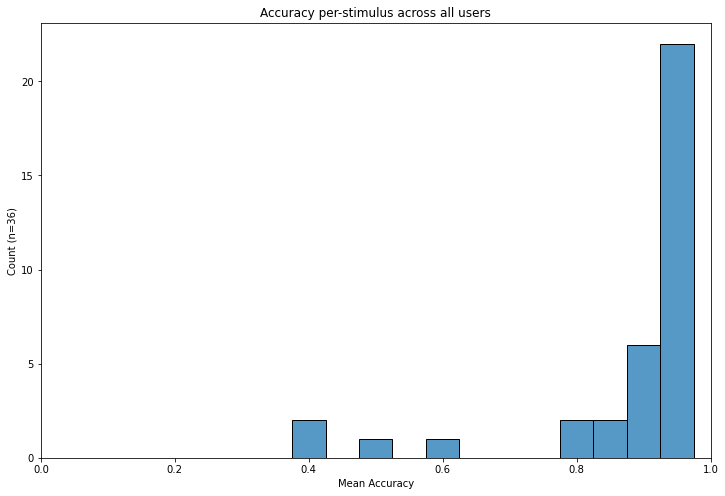

In [39]:
accuracies = []
textures = []
target = "user_id"
challenging_stimuli = []
for index, trials in attention_filtered.groupby(target): 
    accuracy = trials["correct"].mean()
    
    if accuracy < 0.5:
        challenging_stimuli.append((accuracy, trials["stimulus"].iloc[0]))
    accuracies.append(accuracy)
    
    
figure = plt.figure(figsize=(12,8))
sns.histplot(x=accuracies, binwidth=.05)
plt.xlim(0, 1)
plt.xlabel("Mean Accuracy")
plt.ylabel(f"Count (n={len(accuracies)})")
plt.title(f"Accuracy per-stimulus across all users")
plt.savefig(f"figures/{EXPERIMENT_NAME}/mean_accuracy_hist_per_{target}.png")

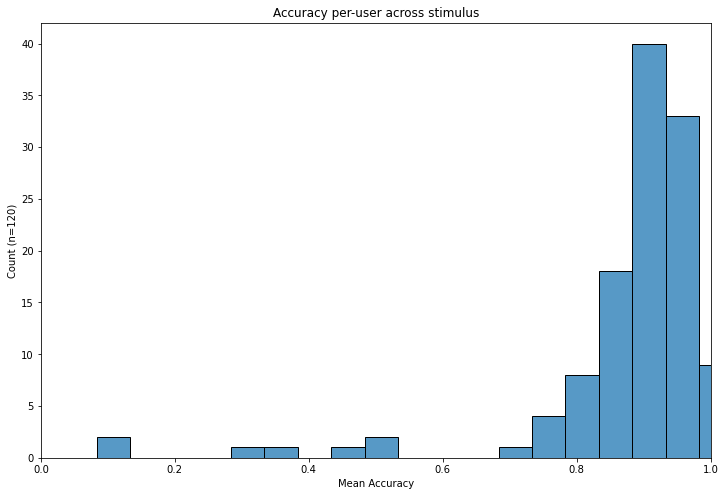

In [40]:
accuracies = []
textures = []
target = "stimulus"
challenging_stimuli = []
for index, trials in attention_filtered.groupby(target): 
    accuracy = trials["correct"].mean()
    
    if accuracy < 0.5:
        challenging_stimuli.append((accuracy, trials["stimulus"].iloc[0]))
    accuracies.append(accuracy)
    
    
figure = plt.figure(figsize=(12,8))
sns.histplot(x=accuracies, binwidth=.05)
plt.xlim(0, 1)
plt.xlabel("Mean Accuracy")
plt.ylabel(f"Count (n={len(accuracies)})")
plt.title(f"Accuracy per-user across stimulus")
plt.savefig(f"figures/{EXPERIMENT_NAME}/mean_accuracy_hist_per_{target}.png")

Text(0.5, 1.0, 'Accuracy by # objects across all users (n=36)')

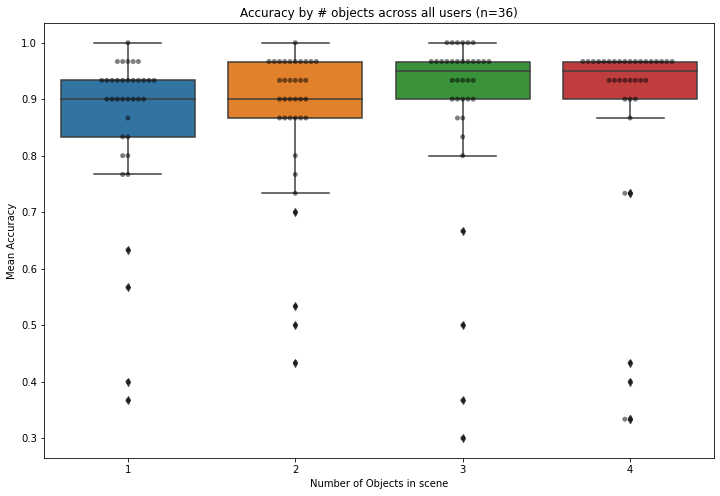

In [41]:
data = []
challenging_stimuli = []
for index, trials in attention_filtered.groupby(["user_id", "n_objs"]): 
    
    accuracy = trials["correct"].mean()
    user_id = trials["user_id"].iloc[0]
    texture_name = trials["n_objs"].iloc[0]
    
    data.append({"accuracy": accuracy, "user_id": user_id, "texture": texture_name})
    
    if accuracy < 0.5:
        challenging_stimuli.append((accuracy, trials["stimulus"].iloc[0]))
    accuracies.append(accuracy)
    

tempdf = pd.DataFrame(data)

figure, ax = plt.subplots(figsize=(12,8))
ax = sns.boxplot(y="accuracy", x="texture", data=tempdf)
ax = sns.swarmplot(y="accuracy", x="texture", color="black", alpha=0.5, data=tempdf)

plt.ylabel("Mean Accuracy")
plt.xlabel(f"Number of Objects in scene")
plt.title(f"Accuracy by # objects across all users (n={len(attention_filtered['user_id'].unique())})")
# plt.savefig(f"figures/{EXPERIMENT_NAME}/mean_accuracy_hist_per_{target}.png")



Text(0.5, 1.0, 'Accuracy by # objects across stimulus (n=120)')

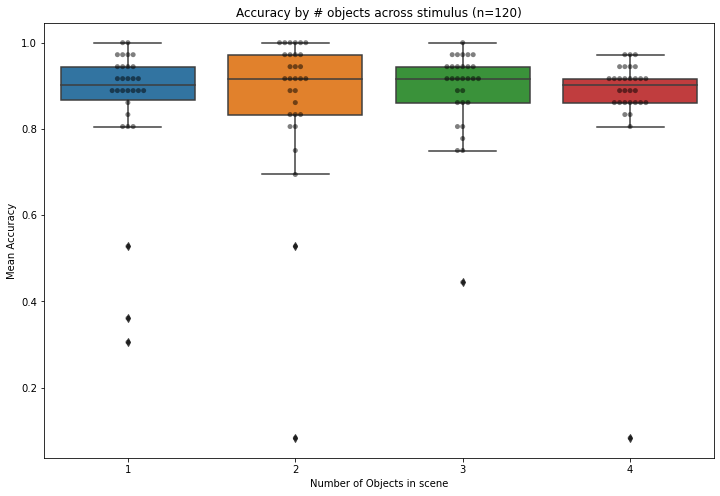

In [42]:
data = []
challenging_stimuli = []
for index, trials in attention_filtered.groupby(["stimulus", "n_objs"]): 
    
    accuracy = trials["correct"].mean()
    stimulus_id = trials["stimulus"].iloc[0]
    n_objs = trials["n_objs"].iloc[0]
    
    data.append({"accuracy": accuracy, "stimulus": stimulus_id, "n_objs": n_objs})
    
    accuracies.append(accuracy)
    

tempdf = pd.DataFrame(data)

figure, ax = plt.subplots(figsize=(12,8))
ax = sns.boxplot(y="accuracy", x="n_objs", data=tempdf)
ax = sns.swarmplot(y="accuracy", x="n_objs", color="black", alpha=0.5, data=tempdf)

plt.ylabel("Mean Accuracy")
plt.xlabel(f"Number of Objects in scene")
plt.title(f"Accuracy by # objects across stimulus (n={len(attention_filtered['stimulus'].unique())})")
# plt.savefig(f"figures/{EXPERIMENT_NAME}/mean_accuracy_hist_per_{target}.png")



# Accuracy across all stimuli

Text(0.5, 1.0, 'Accuracy by texture type across stimulus')

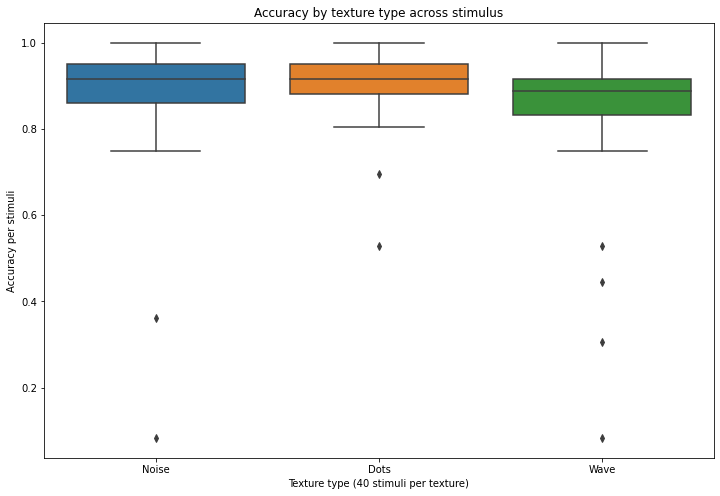

In [43]:
accuracies = []
textures = []
target = "stimulus"
challenging_stimuli = []
for index, trials in attention_filtered.groupby(target): 
    accuracy = trials["correct"].mean()

    
    accuracies.append(accuracy)
    textures.append(trials["texture_name"].iloc[0])
    
    
tempdf = pd.DataFrame({"textures": textures, "accuracies": accuracies})

figure = plt.figure(figsize=(12,8))
sns.boxplot(y="accuracies", x="textures", data=tempdf)

plt.xlabel("Texture type (40 stimuli per texture)")
plt.ylabel(f"Accuracy per stimuli")
plt.title(f"Accuracy by texture type across stimulus")
# plt.savefig(f"figures/{EXPERIMENT_NAME}/mean_accuracy_hist_per_{target}.png")


Text(0.5, 1.0, 'Accuracy by texture type across users')

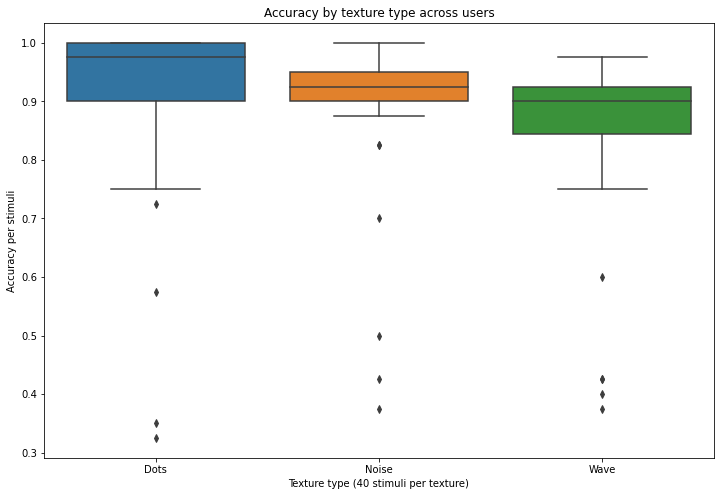

In [44]:
accuracies = []
textures = []
target = "user_id"
challenging_stimuli = []
for index, trials in attention_filtered.groupby([target, "texture_name"]): 
    accuracy = trials["correct"].mean()

    
    accuracies.append(accuracy)
    textures.append(trials["texture_name"].iloc[0])
    
    
tempdf = pd.DataFrame({"textures": textures, "accuracies": accuracies})

figure = plt.figure(figsize=(12,8))
sns.boxplot(y="accuracies", x="textures", data=tempdf)

plt.xlabel("Texture type (40 stimuli per texture)")
plt.ylabel(f"Accuracy per stimuli")
plt.title(f"Accuracy by texture type across users")
# plt.savefig(f"figures/{EXPERIMENT_NAME}/mean_accuracy_hist_per_{target}.png")


#  mIOU


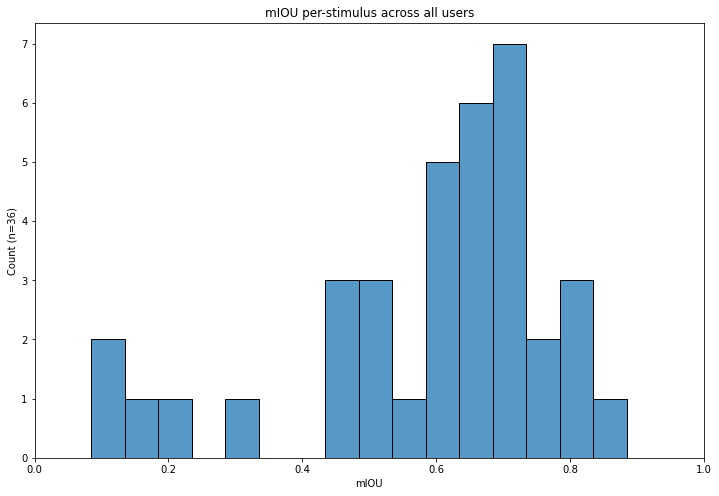

In [45]:
accuracies = []
textures = []
target = "user_id"
challenging_stimuli = []
for index, trials in attention_filtered.groupby(target): 
    accuracy = trials["miou"].mean()
    
    if accuracy < 0.5:
        challenging_stimuli.append((accuracy, trials["stimulus"].iloc[0]))
    accuracies.append(accuracy)
    
    
figure = plt.figure(figsize=(12,8))
sns.histplot(x=accuracies, binwidth=.05)
plt.xlim(0, 1)
plt.xlabel("mIOU")
plt.ylabel(f"Count (n={len(accuracies)})")
plt.title(f"mIOU per-stimulus across all users")
plt.savefig(f"figures/{EXPERIMENT_NAME}/mean_miou_hist_per_{target}.png")

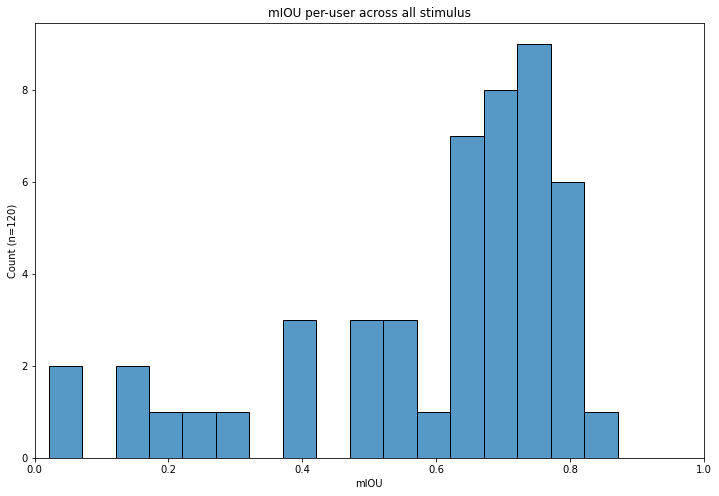

In [46]:
accuracies = []
textures = []
target = "stimulus"
challenging_stimuli = []
for index, trials in attention_filtered.groupby(target): 
    accuracy = trials["miou"].mean()
    
    if accuracy < 0.5:
        challenging_stimuli.append((accuracy, trials["stimulus"].iloc[0]))
    accuracies.append(accuracy)
    
    
figure = plt.figure(figsize=(12,8))
sns.histplot(x=accuracies, binwidth=.05)
plt.xlim(0, 1)
plt.xlabel("mIOU")
plt.ylabel(f"Count (n={len(accuracies)})")
plt.title(f"mIOU per-user across all stimulus")
plt.savefig(f"figures/{EXPERIMENT_NAME}/mean_miou_hist_per_{target}.png")

Text(0.5, 1.0, 'mIOU by # objects across all users (n=36)')

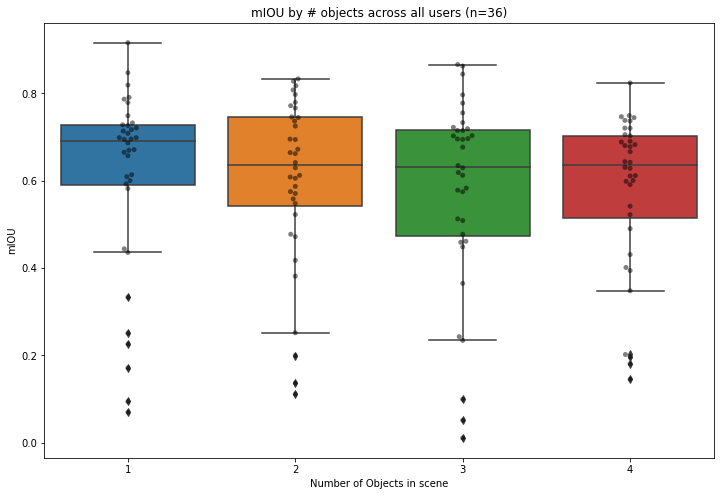

In [47]:
data = []
challenging_stimuli = []
for index, trials in attention_filtered.groupby(["user_id", "n_objs"]): 
    
    accuracy = trials["miou"].mean()
    user_id = trials["user_id"].iloc[0]
    texture_name = trials["n_objs"].iloc[0]
    
    data.append({"accuracy": accuracy, "user_id": user_id, "texture": texture_name})
    
    if accuracy < 0.5:
        challenging_stimuli.append((accuracy, trials["stimulus"].iloc[0]))
    accuracies.append(accuracy)
    

tempdf = pd.DataFrame(data)

figure, ax = plt.subplots(figsize=(12,8))
ax = sns.boxplot(y="accuracy", x="texture", data=tempdf)
ax = sns.swarmplot(y="accuracy", x="texture", color="black", alpha=0.5, data=tempdf)

plt.ylabel("mIOU")
plt.xlabel(f"Number of Objects in scene")
plt.title(f"mIOU by # objects across all users (n={len(attention_filtered['user_id'].unique())})")
# plt.savefig(f"figures/{EXPERIMENT_NAME}/mean_accuracy_hist_per_{target}.png")



Text(0.5, 1.0, 'mIOU by # objects across all stimulus (n=60)')

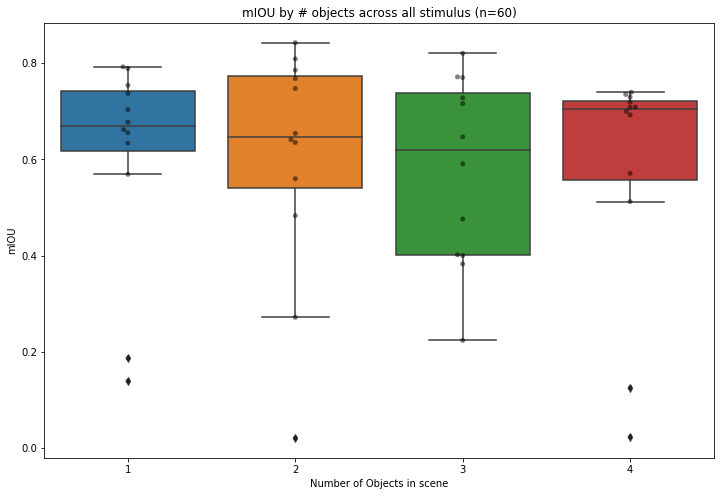

In [48]:
data = []
challenging_stimuli = []
for index, trials in attention_filtered.groupby(["stimulus", "n_objs"]): 
    
    accuracy = trials["miou"].mean()
    user_id = trials["user_id"].iloc[0]
    texture_name = trials["n_objs"].iloc[0]
    
    data.append({"accuracy": accuracy, "user_id": user_id, "texture": texture_name})
    
    if accuracy < 0.5:
        challenging_stimuli.append((accuracy, trials["stimulus"].iloc[0]))
    accuracies.append(accuracy)
    

tempdf = pd.DataFrame(data)

figure, ax = plt.subplots(figsize=(12,8))
ax = sns.boxplot(y="accuracy", x="texture", data=tempdf)
ax = sns.swarmplot(y="accuracy", x="texture", color="black", alpha=0.5, data=tempdf)

plt.ylabel("mIOU")
plt.xlabel(f"Number of Objects in scene")
plt.title(f"mIOU by # objects across all stimulus (n=60)")
# plt.savefig(f"figures/{EXPERIMENT_NAME}/mean_accuracy_hist_per_{target}.png")



Text(0.5, 1.0, 'mIOU by texture type across all users (n=36)')

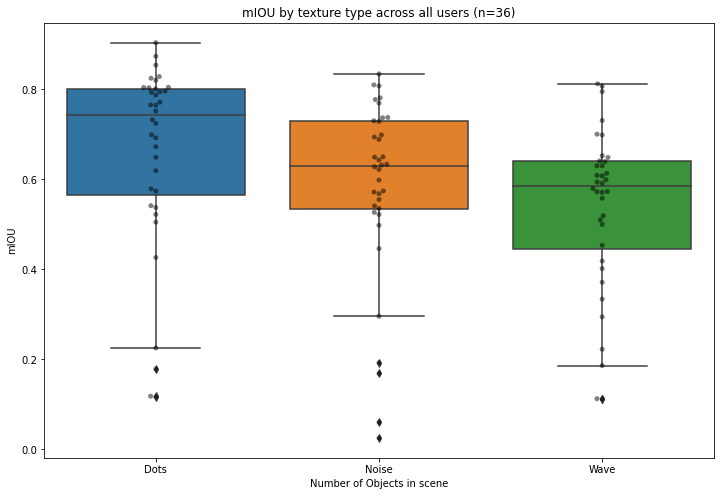

In [49]:
data = []
challenging_stimuli = []
for index, trials in attention_filtered.groupby(["user_id", "texture_name"]): 
    
    accuracy = trials["miou"].mean()
    user_id = trials["user_id"].iloc[0]
    texture_name = trials["texture_name"].iloc[0]
    
    data.append({"accuracy": accuracy, "user_id": user_id, "texture": texture_name})
    
    if accuracy < 0.5:
        challenging_stimuli.append((accuracy, trials["stimulus"].iloc[0]))
    accuracies.append(accuracy)
    

tempdf = pd.DataFrame(data)

figure, ax = plt.subplots(figsize=(12,8))
ax = sns.boxplot(y="accuracy", x="texture", data=tempdf)
ax = sns.swarmplot(y="accuracy", x="texture", color="black", alpha=0.5, data=tempdf)

plt.ylabel("mIOU")
plt.xlabel(f"Number of Objects in scene")
plt.title(f"mIOU by texture type across all users (n={len(attention_filtered['user_id'].unique())})")
# plt.savefig(f"figures/{EXPERIMENT_NAME}/mean_accuracy_hist_per_{target}.png")



Text(0.5, 1.0, 'mIOU by texture type across all stimulus (n=60)')

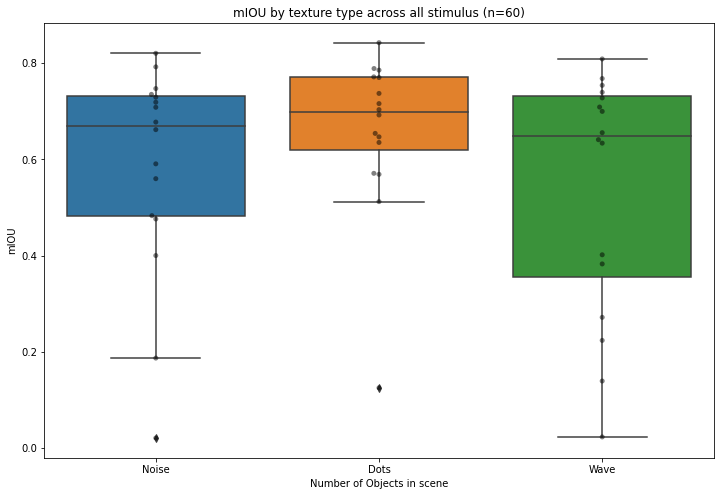

In [50]:
data = []
challenging_stimuli = []
for index, trials in attention_filtered.groupby(["stimulus", "texture_name"]): 
    
    accuracy = trials["miou"].mean()
    user_id = trials["user_id"].iloc[0]
    texture_name = trials["texture_name"].iloc[0]
    
    data.append({"accuracy": accuracy, "user_id": user_id, "texture": texture_name})
    
    if accuracy < 0.5:
        challenging_stimuli.append((accuracy, trials["stimulus"].iloc[0]))
    accuracies.append(accuracy)
    

tempdf = pd.DataFrame(data)

figure, ax = plt.subplots(figsize=(12,8))
ax = sns.boxplot(y="accuracy", x="texture", data=tempdf)
ax = sns.swarmplot(y="accuracy", x="texture", color="black", alpha=0.5, data=tempdf)

plt.ylabel("mIOU")
plt.xlabel(f"Number of Objects in scene")
plt.title(f"mIOU by texture type across all stimulus (n=60)")
# plt.savefig(f"figures/{EXPERIMENT_NAME}/mean_accuracy_hist_per_{target}.png")




In [51]:
percent_correct, url = challenging_stimuli[0]

def add_box(box, ax, alpha=0.8, color="red", linewidth=5):
    if len(box) != 4:
        box = process_box(box)
    width = box[2] - box[0]
    height = box[3] - box[1]
    if not color or color == "random":
        import random
        color = "#%06x" % random.randint(0, 0xFFFFFF)
        
    rect = patches.Rectangle((box[0], box[1]), width, height, linewidth=linewidth, edgecolor=color, 
                             alpha=alpha, facecolor='none')
    ax.add_patch(rect)
    return ax

def plot_trial(trial):
    fig, ax = plt.subplots(figsize=(16,12))
    print(trial["user_id"])
    
    gt_bb = trial["gt_bounding_box"]
    s_bb = trial["subject_bounding_box"]
    
    if gt_bb:
        add_box(gt_bb, ax, color="red", alpha=0.75)
        
    if s_bb:
        add_box(s_bb, ax, color="blue", alpha=0.75)
        
    url = trial["stimulus"]
    image = download_from_url(url)

    probe_location = trial["probe_location"]
    
    ax.imshow(image, cmap="gray")

    # Add probes
    probe = patches.Circle(probe_location, radius=12, color="#69597f", alpha=0.8)
    ax.add_patch(probe)
    probe = patches.Circle(probe_location, radius=4, color="#ff0601", alpha=1)
    ax.add_patch(probe)

    return fig

60c2195a50327b9b3542b72d


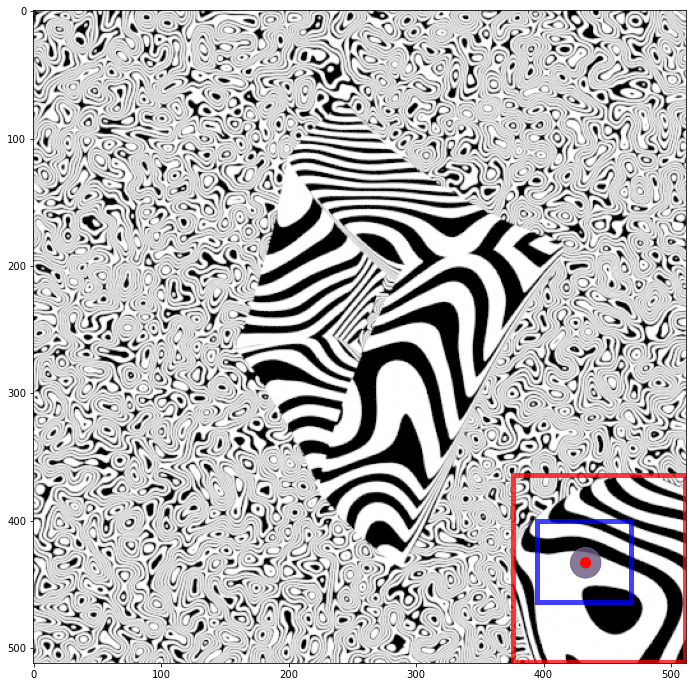

5f15f619399eaf744fe91aaa


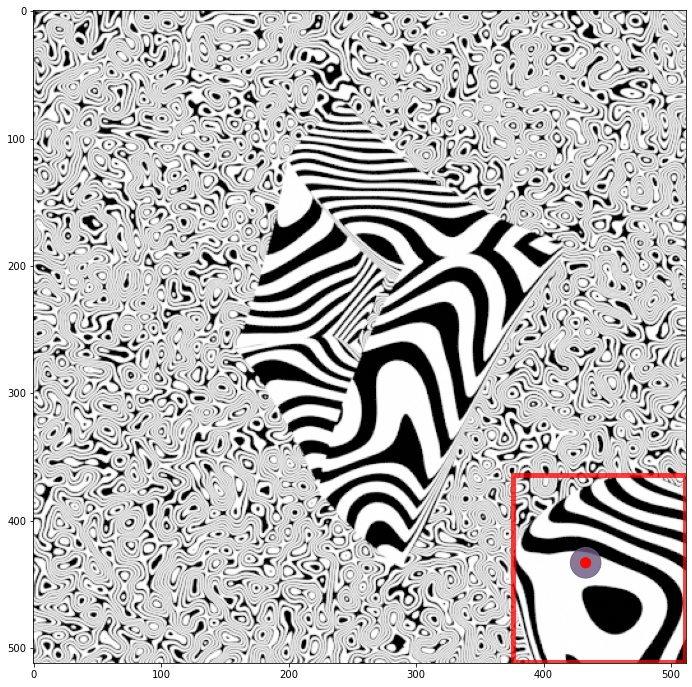

5ee358aa0e39ba000b86d295


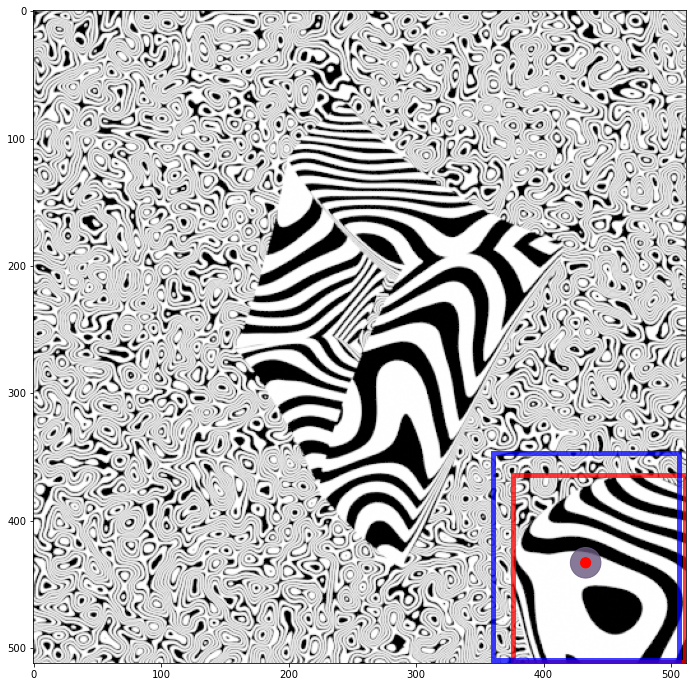

5f15f619399eaf744fe91aaa


KeyboardInterrupt: 

In [52]:
for index, trial in attention_filtered.iterrows():
    fig=plot_trial(trial)
    plt.show()
    plt.close()

In [53]:
avg_bboxes = False
run_plots = True

save_path = "/Users/yoni/Desktop/static_detection_v1_user_bboxes/"
if not os.path.exists(save_path):
    os.mkdir(save_path)
    
if run_plots:
    for index, trials in attention_filtered.groupby("stimulus"):

        url = index
        image = download_from_url(url)

        # Add probes
        probe_location = trials.iloc[0]["probe_location"]
        probe_touching = trials.iloc[0]["probe_touching"]

        if not probe_touching:
            continue 

        fig, ax = plt.subplots(1,1, figsize=(16, 12))
        image = download_from_url(url)

        ax.imshow(image, cmap="gray")

        probe = patches.Circle(probe_location, radius=12, color="#69597f", alpha=0.8)
        ax.add_patch(probe)

        probe = patches.Circle(probe_location, radius=4, color="#ff0601", alpha=1)
        ax.add_patch(probe)

        gt_bb = trials.iloc[0]["gt_bounding_box"]
        ax = add_box(gt_bb, ax, color="red", linewidth=10, alpha=1)

        avg_bb = []
        count = 0
        for i, trial in trials.iterrows():
            s_bb = trial["subject_bounding_box"]
            if s_bb:
                if avg_bboxes:
                    box = np.array(process_box(s_bb))
                    count += 1
                    if not len(avg_bb):
                        avg_bb.append(box)
                    else:
                        avg_bb.append(box)
                else: 
                    add_box(s_bb, ax, alpha=0.5, linewidth=5, color="random")

        if avg_bboxes:
            avg_bb = np.array(avg_bb).mean(axis=0)
            add_box(avg_bb, ax, alpha=0.9, linewidth=5, color="blue")
            miou = calc_mIOU(avg_bb, gt_bb)
            print(miou)
        

        trial_name = url.split(".com")[1][1:].replace("/", "-")
        trial_name = trial_name.replace("-images", "")

        plt.title(trial_name)
        plt.savefig(os.path.join(save_path, trial_name + ".png"))
        plt.show()
        plt.close()

KeyboardInterrupt: 

# Regress parameters that make this difficult

In [54]:
import statsmodels.formula.api as sm_api
import statsmodels.api as sm


In [55]:
attention_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4320 entries, 8 to 4910
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   rt                    4320 non-null   int64  
 1   stimulus              4320 non-null   object 
 2   response              4320 non-null   int64  
 3   correct               4320 non-null   bool   
 4   probe_location        4320 non-null   object 
 5   probe_touching        4320 non-null   bool   
 6   subject_bounding_box  4320 non-null   object 
 7   trial_type            4320 non-null   object 
 8   trial_index           4320 non-null   int64  
 9   time_elapsed          4320 non-null   int64  
 10  internal_node_id      4320 non-null   object 
 11  background_texture    4320 non-null   object 
 12  frame_idx             4320 non-null   int64  
 13  gt_bounding_box       4320 non-null   object 
 14  image_url             4320 non-null   object 
 15  mask_idx             

In [56]:
camera_loc = np.array([18.5, -18.2, 12.2])

## Extract texture params

In [99]:
# Object parameters
get_distortion = lambda x: x["params"].get("Distortion", x["params"].get("Scale"))

attention_filtered["obj_scale"] = attention_filtered["obj_texture_data"].apply(lambda x: x["params"]["Scale"])
attention_filtered["obj_distortion"] = attention_filtered["obj_texture_data"].apply(get_distortion)

# Background parameters
attention_filtered["background_scale"] = attention_filtered["background_texture"].apply(
    lambda x: x["params"]["Scale"])
attention_filtered["background_distortion"] = attention_filtered["background_texture"].apply(get_distortion)

camera_dist = lambda x: np.sqrt(np.sum((np.array(x) - camera_loc) ** 2))
attention_filtered["obj_distance"] = attention_filtered["obj_location_data"].apply(camera_dist)

## Combine them

In [100]:
attention_filtered["scale_diff"] = attention_filtered["obj_scale"] - attention_filtered["background_scale"]
attention_filtered["distortion_diff"] = attention_filtered["obj_distortion"] - \
                                        attention_filtered["background_distortion"]
attention_filtered["texture_categorical"] = attention_filtered["texture_name"].astype("category")

## Normalize everything

In [116]:
attention_filtered["scale_diff"] = (attention_filtered["scale_diff"] - attention_filtered["scale_diff"].mean()) / \
                                    attention_filtered["scale_diff"].std()
    
attention_filtered["distortion_diff"] = (attention_filtered["distortion_diff"] - attention_filtered["distortion_diff"].mean()) / \
                                    attention_filtered["distortion_diff"].std()
    
attention_filtered["miou_norm"] = (attention_filtered["miou"] - attention_filtered["miou"].mean()) / \
                                    attention_filtered["miou"].std()
    
attention_filtered["obj_distance"] = (attention_filtered["obj_distance"] - attention_filtered["obj_distance"].mean()) / \
                                    attention_filtered["obj_distance"].std()
    

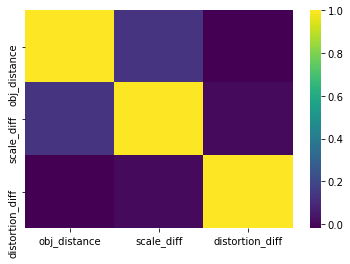

In [131]:
fig, ax = plt.subplots()
exog_vars = ["obj_distance", "scale_diff", "distortion_diff"]
exog = attention_filtered[exog_vars]
sns.heatmap(exog.corr(), cmap="viridis")
plt.show()

keep_idxs = attention_filtered["miou"].notna()
X = sm.add_constant(exog[keep_idxs])
endog = attention_filtered["miou_norm"][keep_idxs]
model = sm.OLS(exog=X, endog=endog)
result = model.fit()

In [132]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:              miou_norm   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     20.41
Date:                Thu, 31 Mar 2022   Prob (F-statistic):           5.33e-13
Time:                        13:59:37   Log-Likelihood:                -2421.3
No. Observations:                1728   AIC:                             4851.
Df Residuals:                    1724   BIC:                             4872.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0005      0.024     

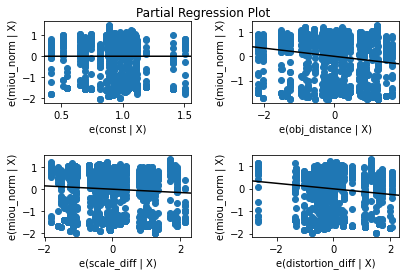

In [133]:
# fig = plt.figure(figsize=(10, 8))
fig = sm.graphics.plot_partregress_grid(result)
fig.tight_layout(pad=2)
